<a href="https://colab.research.google.com/github/Baragouine/Super-Mario-RL/blob/master/SuperMarioBrosRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Auteurs
SAID Raoufdine 11502286  
KORICHI Ilyes 11810510  
ABDULLATIEF Noauffal 11803762  
EL AZZOUZI Mohamed 11804134  

## Import
Pour effectuer l'entraînement ou le test de l'agent, il est nécessaire d'exécuter les cellules de ce bloc.

In [ ]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from matplotlib import pyplot as plt
from gym.wrappers import GrayScaleObservation
from gym import wrappers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/home/rsaid/anaconda3/envs/rl-mario/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# device initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
checkpoints_folder = "checkpoints"

In [ ]:
# Create checkpoint folder if not exists
import os
if not os.path.exists("./" + checkpoints_folder):
    os.makedirs("./" + checkpoints_folder)

## Visualisation d'une partie
Ce bloc de code permet de jouer un épisode en utilisant une stratégie aléatoire. Il n'est pas nécessaire de l'exécuter ni pour l'entraînement ni pour le test de l'agent.

In [ ]:
# Environment initialization
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Put the environment in a wrapper to save the episode video
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [ ]:
# Start a new episode and get the first environment state
state = env.reset()
done = False

# Game loop
while not done:
    # Random action
    state, reward, done, info = env.step(env.action_space.sample())
    print(info)
    # Show the game on the screen
    env.render()
env.close()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
{'coins': 1, 'flag_get': False, 'life': 0, 'score': 500, 'stage': 1, 'status': 'small', 'time': 249, 'world': 1, 'x_pos': 556, 'x_pos_screen': 112, 'y_pos': 89}
{'coins': 1, 'flag_get': False, 'life': 0, 'score': 500, 'stage': 1, 'status': 'small', 'time': 249, 'world': 1, 'x_pos': 556, 'x_pos_screen': 112, 'y_pos': 93}
{'coins': 1, 'flag_get': False, 'life': 0, 'score': 500, 'stage': 1, 'status': 'small', 'time': 249, 'world': 1, 'x_pos': 557, 'x_pos_screen': 112, 'y_pos': 96}
{'coins': 1, 'flag_get': False, 'life': 0, 'score': 500, 'stage': 1, 'status': 'small', 'time': 249, 'world': 1, 'x_pos': 558, 'x_pos_screen': 112, 'y_pos': 99}
{'coins': 1, 'flag_get': False, 'life': 0, 'score': 500, 'stage': 1, 'status': 'small', 'time': 249, 'world': 1, 'x_pos': 559, 'x_pos_screen': 112, 'y_pos': 101}
{'coins': 1, 'flag_get': False, 'life': 0, 'score': 500, 'stage': 1, 'status': 'small', 'time': 249, 'world': 1, 'x_

## Analyse du retour de env.step en nuance de gris
Ce bloc permet d'obtenir une meilleure compréhension des informations renvoyées par l'environnement lors de l'exécution de env.step, telles que l'état, la récompense, le statut de l'épisode et d'autres informations.  
  
Il n'est pas nécessaire de l'exécuter pour l'entraînement ou le test de l'agent.

In [ ]:
# Environment initialization
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Put the environment in a wrapper
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [ ]:
state = env.reset()
# Récupération des valeurs de retour
state, reward, done, info = env.step(env.action_space.sample())

In [ ]:
# Contenu de state
state

array([[[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       ...,

       [[240, 208, 176],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [  0,   0,   0]],

       [[240, 208, 176],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[228,  92,  16],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [228,  92,  16]]

In [ ]:
# Shape de state
state.shape

(240, 256, 3)

In [ ]:
# reward
reward

0.0

In [ ]:
# info
info

{'coins': 0,
 'flag_get': False,
 'life': 2,
 'score': 0,
 'stage': 1,
 'status': 'small',
 'time': 400,
 'world': 1,
 'x_pos': 40,
 'x_pos_screen': 40,
 'y_pos': 79}

## Déclaration des hyperparamètres
Pour entraîner ou tester l'agent vous devez exécuter la cellule ci-dessous.

In [ ]:
training_episodes = 1000000                 # Max number of training episodes
gamma = .99                                 # Discount factor used in Q-function
learning_rate = .0001                       # Learning rate of the optimizer
batch_size = 256
epsilon_max = 1.                            # Maximum epsilon value at 1.
epsilon_min = .001                          # Minimum epsilon value at .001
epsilon_decay = .995                        # Epsilon decay factor at .995
replay_memory_capacity = 50000              # Limit memory capacity at 2000
start_optimize = 2000                       # Minimal memory size to start optimize
update_interval = 50                        # Save model every 50 steps
n_frame = 4

## wrappers
Pour entraîner ou tester l'agent vous devez exécuter la cellule ci-dessous.

In [ ]:
'''
Code from OpenAI baseline
https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py
'''

import numpy as np
import os
os.environ.setdefault('PATH', '')
from collections import deque
import gym
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)
from gym.wrappers import TimeLimit


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]

def make_atari(env_id, max_episode_steps=None):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=True):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env


class EpisodicLifeMario(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped._life
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped._life
        return obs

def wrap_mario(env):
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeMario(env)
    env = WarpFrame(env)
    env = ScaledFloatFrame(env)
    # env = custom_reward(env)
    env = FrameStack(env, 4)
    return env

## Replay memory
Pour entraîner ou tester l'agent, il est impératif d'exécuter la cellule ci-dessous.

In [ ]:
class ReplayMemory(object):
  def __init__(self, size):
    self.memory = deque(maxlen=size)

  def push(self, transition):
    self.memory.append(transition)

  def sample(self, n):
    return random.sample(self.memory, n)

  def __len__(self):
    return len(self.memory)

## Création de l'Agent
Pour entraîner ou tester l'agent vous devez exécuter la cellule ci-dessous.

In [ ]:
class Agent():
  def __init__(self, device, replay_memory, q, q_target, optimizer, loss_function, env):
    self._device = device
    self._rm = replay_memory
    self._epsilon = epsilon_max
    self._q = q
    self._q_target = q_target
    self._optimizer = optimizer
    self._loss_function = loss_function
    self._env = env
    # History
    self._reward_hist = []

  def arrange(self, s):
    if not type(s) == "numpy.ndarray":
      s = np.array(s)
    assert len(s.shape) == 3
    ret = np.transpose(s, (2, 0, 1))
    return np.expand_dims(ret, 0)

  def train(self, first_episode = 0, last_episode = training_episodes, epsilon = epsilon_max):
    self._epsilon = epsilon
    start = time.time()
    for episode in range(first_episode, last_episode):
      # Run 1 episode
      episode_reward, loss, stage = self._run_episode()
      self._reward_hist.append(episode_reward)
      if episode % update_interval == 0:
        print('model saved: ', f'{time.time() - start:.2f}s')
        self._copy_weights(self._q, self._q_target)
        torch.save(self._q.state_dict(), "./" + checkpoints_folder + "/" + str(episode) + "_mario_q.pth")
        torch.save(self._q_target.state_dict(), "./" + checkpoints_folder + "/" + str(episode) + "_mario_q_target.pth")
      print("%s | episode : %d / %d | score : %f | loss : %.2f | stage : %d | time : %d s | epsilon : %f "
             % (
             self._device,
             episode + 1, training_episodes,
             episode_reward,
             loss,
             stage,
             time.time() - start,
             self._epsilon
            )
      )
      with open("./" + checkpoints_folder + "/logs.csv", 'a') as f:
        f.write("%s;%d;%f;%f;%d;%d;%f\n"
             % (
             self._device,
             episode,
             episode_reward,
             loss,
             stage,
             time.time() - start,
             self._epsilon
            ))
    print(f'training done in {time.time() - start:.2f}s')
    self._plot_history()

  def _optimize(self):
    state, reward, action_index, next_state, done = \
                              list(map(list, zip(*self._rm.sample(batch_size))))
    state = np.array(state).squeeze()
    next_state = np.array(next_state).squeeze()
    a_max = self._q(next_state).max(1)[1].unsqueeze(-1)
    reward = torch.FloatTensor(reward).unsqueeze(-1).to(device)
    done = torch.FloatTensor(done).unsqueeze(-1).to(device)
    with torch.no_grad():
      y = reward + gamma * self._q_target(next_state).gather(1, a_max) * done
    action_index = torch.tensor(action_index).unsqueeze(-1).to(device)
    q_value = torch.gather(self._q(state), dim=1,\
                           index=action_index.view(-1, 1).long())
    loss = self._loss_function(q_value, y).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

  def _copy_weights(self, q, q_target):
    q_dict = q.state_dict()
    q_target.load_state_dict(q_dict)

  def _run_episode(self):
    episode_reward = 0.0
    state = self.arrange(env.reset())
    done = False
    loss = 0.0

    while not done:
      if random.uniform(0, 1) <= self._epsilon:
        action_index = self._env.action_space.sample()
      else:
        if self._device == "cpu":
          action_index = np.argmax(self._q(s).detach().numpy())
        else:
          action_index = np.argmax(self._q(state).cpu().detach().numpy())
      next_state, reward, done, info = self._env.step(action_index)
      next_state = self.arrange(next_state)
      episode_reward += reward
      reward = np.sign(reward) * (np.sqrt(abs(reward) + 1) - 1) + 0.001 * reward
      self._rm.push((state, float(reward), int(action_index), next_state, int(1 - done)))
      state = next_state
      stage = env.unwrapped._stage
      if len(self._rm) >= start_optimize:
        loss += self._optimize()
        self._epsilon = max(epsilon_min, self._epsilon * epsilon_decay)

    return episode_reward, loss, stage

  def _plot_history(self):
    plt.figure(figsize=(10, 5))
    plt.plot(self._reward_hist)
    plt.xlabel('episodes')
    plt.ylabel('reward')
    plt.title('Reward per episode')
    plt.show()

  def load_model(self, q_path, q_target_path):
    self._q = Model(n_frame, env.action_space.n, device).to(device)
    self._q_target = Model(n_frame, env.action_space.n, device).to(device)
    self._q.load_state_dict(torch.load(q_path))
    self._q_target.load_state_dict(torch.load(q_target_path))

  def real_episode(self, env, sleep_first_rend = False):
    first_rend = sleep_first_rend
    total_score = 0.0
    done = False
    state = self.arrange(env.reset())
    while not done:
      env.render()
      if device == 'cpu':
        a = np.argmax(self._q(state).detach().numpy())
      else:
        a = np.argmax(self._q(state).cpu().detach().numpy())
      next_state, reward, done, info = env.step(a)
      next_state = self.arrange(next_state)
      total_score += reward
      state = next_state
      time.sleep(0.016)
      if first_rend:
        time.sleep(10)
        first_rend = False

    stage = env.unwrapped._stage
    print("Total score : %f | stage : %d" % (total_score, stage))

## Model
Pour entraîner ou tester l'agent vous devez exécuter les cellules ci-dessous.

In [ ]:
def init_weights(m):
  if type(m) == nn.Conv2d:
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

In [ ]:
class Model(nn.Module):
  def __init__(self, n_frame, n_action, device):
    super(Model, self).__init__()
    self.layer1 = nn.Conv2d(n_frame, 32, 8, 4)
    self.layer2 = nn.Conv2d(32, 64, 3, 1)
    self.fc = nn.Linear(20736, 512)
    self.q = nn.Linear(512, n_action)
    self.v = nn.Linear(512, 1)

    self.device = device
    self.seq = nn.Sequential(self.layer1, self.layer2, self.fc, self.q, self.v)

    self.seq.apply(init_weights)

  def forward(self, x):
    if type(x) != torch.Tensor:
      x = torch.FloatTensor(x).to(self.device)
    x = torch.relu(self.layer1(x))
    x = torch.relu(self.layer2(x))
    x = x.view(-1, 20736)
    x = torch.relu(self.fc(x))
    adv = self.q(x)
    v = self.v(x)
    q = v + (adv - 1 / adv.shape[-1] * adv.max(-1, True)[0])

    return q

## Entraînement de l'agent
Si vous voulez entrainer l'agent exécuter toutes les cellules de ce bloc.  
Si vous voulez tester l'agent n'exécuter que les deux premières cellules de ce bloc.

In [ ]:
# Environment initialization
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Put the environment in a wrapper
env = JoypadSpace(env, COMPLEX_MOVEMENT)
# personal wrap
env = wrap_mario(env)

In [ ]:
# models and opimizer
q = Model(n_frame, env.action_space.n, device).to(device)
q_target = Model(n_frame, env.action_space.n, device).to(device)
optimizer = optim.Adam(q.parameters(), learning_rate)
loss_function = F.smooth_l1_loss
replay_memory = ReplayMemory(replay_memory_capacity)

# agent
agent = Agent(device, replay_memory, q, q_target, optimizer, loss_function, env)

In [ ]:
# Training: Executer cette cellule uniquement que si vous souhaiter entrainer le modèle vous même
agent.train()

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
cuda | episode : 24322 / 1000000 | score : 6595.000000 | loss : 539.51 | stage : 3 | time : 511503 s | epsilon : 0.001000 
cuda | episode : 24323 / 1000000 | score : 6413.000000 | loss : 501.16 | stage : 3 | time : 511532 s | epsilon : 0.001000 
cuda | episode : 24324 / 1000000 | score : 1301.000000 | loss : 98.18 | stage : 3 | time : 511538 s | epsilon : 0.001000 
cuda | episode : 24325 / 1000000 | score : 6468.000000 | loss : 509.12 | stage : 3 | time : 511570 s | epsilon : 0.001000 
cuda | episode : 24326 / 1000000 | score : 1125.000000 | loss : 94.97 | stage : 3 | time : 511576 s | epsilon : 0.001000 
cuda | episode : 24327 / 1000000 | score : 6464.000000 | loss : 541.04 | stage : 3 | time : 511610 s | epsilon : 0.001000 
cuda | episode : 24328 / 1000000 | score : 1274.000000 | loss : 101.59 | stage : 3 | time : 511617 s | epsilon : 0.001000 
cuda | episode : 24329 / 1000000 | score : 6397.000000 | loss :

KeyboardInterrupt: ignored

## Test du modèle
Exécuter les cellules de ce bloc uniquement si vous voulez tester l'agent, vous pouvez choisir le fichier contenant les poids du modèle pré-entrainer.

In [ ]:
# Environment initialization
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Put the environment in a wrapper
env = JoypadSpace(env, COMPLEX_MOVEMENT)
# personal wrap
env = wrap_mario(env)

agent.load_model("./" + checkpoints_folder + "/29000_mario_q.pth", "./" + checkpoints_folder + "/29000_mario_q_target.pth")
agent.real_episode(env)

Total score : 6538.000000 | stage : 3


In [ ]:
env.close()

## Résultats
Pour visualiser les différentes métriques du modèle généré pendant l'entraînement, il est nécessaire d'exécuter les cellules de ce bloc.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("./" + checkpoints_folder + "/logs.csv", sep=';', header=None)
df.columns = ["cuda", "episode", "score", "loss", "stage", "time", "epsilon"]
df.head()

,cuda,episode,score,loss,stage,time,epsilon
0,cuda,0,132.0,0.000000,1,1,1.000000
1,cuda,1,494.0,76.603477,1,24,0.234893
2,cuda,2,628.0,18.488340,1,28,0.156509
3,cuda,3,861.0,28.063334,1,33,0.082394
4,cuda,4,250.0,6.241976,1,34,0.070890


In [ ]:
def plot_data(data, title, ylabel, xlabel = 'episodes'):
  plt.figure(figsize=(10, 5))
  plt.plot(data)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

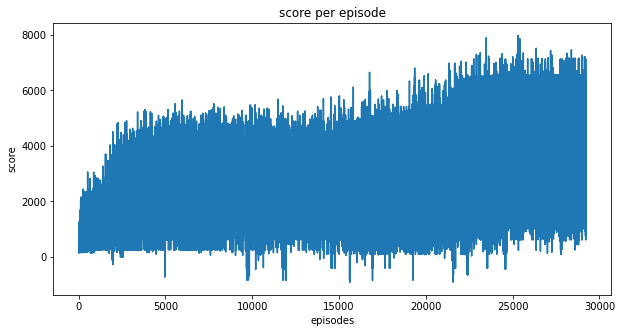

In [ ]:
plot_data(df["score"], 'score per episode', 'score')

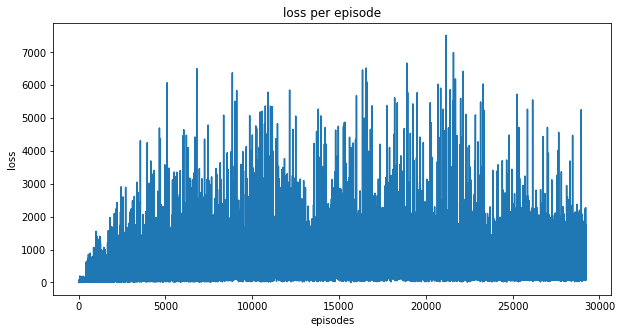

In [ ]:
plot_data(df["loss"], 'loss per episode', 'loss')

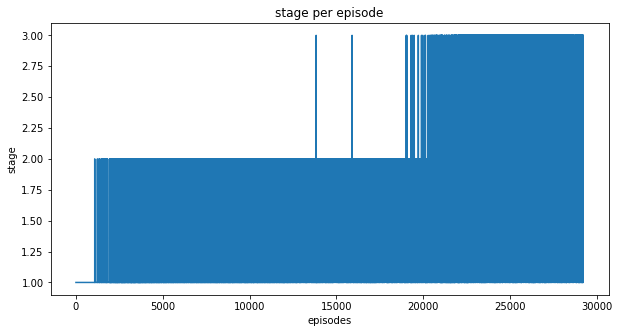

In [ ]:
plot_data(df["stage"], 'stage per episode', 'stage')